# Hidden Markov Model

In [1]:
using RxInfer, Distributions, Random, LinearAlgebra, StableRNGs, PyPlot

### Data generation

In [2]:
function generate_data(nr_categories, nr_words, nr_supervised, nr_unsupervised; rng = MersenneTwister(123))

    # Specify priors
    transition_prior = ones(nr_categories)
    emission_prior = fill(0.1, nr_words)
    
    # Generate transition matrix
    transition_prob = rand(rng, Dirichlet(transition_prior), nr_categories)
    emission_prob = rand(rng, Dirichlet(emission_prior), nr_categories)

    # Generate data
    start_prob = fill(1/nr_categories, nr_categories)

    # Generate supervised data
    categories_supervised = zeros(Int, nr_supervised)
    words_supervised = zeros(nr_supervised)
    for k in 1:nr_supervised
        if k == 1
            categories_supervised[k] = rand(rng, Categorical(start_prob))
        else
            categories_supervised[k] = rand(rng, Categorical(transition_prob[:, categories_supervised[k-1]]))
        end
        words_supervised[k] = rand(rng, Categorical(emission_prob[:, categories_supervised[k]]))
    end

    # Generate unsupervised data
    categories_unsupervised = zeros(Int, nr_unsupervised)
    words_unsupervised = zeros(nr_unsupervised)
    for k in 1:nr_unsupervised
        if k == 1
            categories_unsupervised[k] = rand(rng, Categorical(start_prob))
        else
            categories_unsupervised[k] = rand(rng, Categorical(transition_prob[:, categories_unsupervised[k-1]]))
        end
        words_unsupervised[k] = rand(rng, Categorical(emission_prob[:, categories_unsupervised[k]]))
    end

    # return data
    return transition_prior, emission_prior, transition_prob, emission_prob, start_prob, categories_supervised, words_supervised, categories_unsupervised, words_unsupervised

end

generate_data (generic function with 1 method)

In [3]:
transition_prior, emission_prior, T_transition_true, T_observation_true, start_prob, categories_supervised, words_supervised, words_unsupervised = generate_data(3, 10, 100, 500)

([1.0, 1.0, 1.0], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.048930752277978766 0.31044346482332136 0.40640989555969836; 0.7548197244253347 0.30869332504521413 0.20614012687204483; 0.1962495232966865 0.38086321013146474 0.38744997756825683], [0.05328230227636486 0.006546110210733078 3.645210836367787e-5; 0.014500745665169701 0.06901513097858238 2.8347988591645368e-15; … ; 4.638276871321641e-6 1.144810532301559e-9 0.00010734640919651779; 0.0003812620523199944 1.0339480696895998e-21 1.8495882444662197e-12], [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [3, 3, 3, 1, 2, 1, 2, 1, 2, 1  …  3, 1, 2, 2, 3, 3, 2, 2, 1, 3], [8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 5.0, 3.0, 5.0, 3.0  …  8.0, 3.0, 5.0, 5.0, 8.0, 8.0, 5.0, 8.0, 3.0, 8.0], [2, 3, 1, 2, 1, 2, 3, 2, 2, 2  …  1, 2, 2, 1, 2, 1, 2, 1, 2, 2], [5.0, 8.0, 3.0, 5.0, 3.0, 5.0, 8.0, 5.0, 5.0, 8.0  …  3.0, 5.0, 5.0, 3.0, 5.0, 3.0, 8.0, 3.0, 2.0, 8.0])

### Model specification

In [4]:
@model function hidden_markov_model(T_transition_prior, T_emission_prior, nr_samples_supervised, nr_samples_unsupervised)
    
    # priors
    T_transition ~ MatrixDirichlet(T_transition_prior)
    T_observation ~ MatrixDirichlet(T_emission_prior)

    #########################
    ###  supervised part  ###
    #########################

    # variables
    zc_supervised = randomvar(nr_samples_supervised + 1)
    yc_supervised = randomvar(nr_samples_supervised)
    z_supervised = datavar(Vector{Int64}, nr_samples_supervised)
    y_supervised = datavar(Vector{Int64}, nr_samples_supervised)

    zc_supervised[1] ~ Categorical(fill(1/3, 3))
    for k in 1:length(z_supervised)
        zc_supervised[k+1] ~ Transition(zc_supervised[k], T_transition)
        yc_supervised[k] ~ Transition(zc_supervised[k+1], T_observation)

        # observations
        zc_supervised[k] ~ Categorical(z_supervised[k])
        yc_supervised[k] ~ Categorical(y_supervised[k])
    end

    #########################
    ### unsupervised part ###
    #########################

    # variables
    z_unsupervised = randomvar(nr_samples_unsupervised + 1)
    y_unsupervised = datavar(Vector{Int64}, nr_samples_unsupervised)

    z_unsupervised[1] ~ Categorical(ones(size(T_transition_prior, 1)) ./ size(T_transition_prior, 1))

    # specify transitions
    for k in 1:length(z_unsupervised) - 1
        z_unsupervised[k+1] ~ Transition(z_unsupervised[k], T_transition)
        y_unsupervised[k] ~ Transition(z_unsupervised[k+1], T_observation)
    end

end;

In [5]:
@constraints function hidden_markov_model_constraints()
    q(zc_supervised, yc_supervised, z_unsupervised, T_transition, T_observation) = q(zc_supervised, yc_supervised)q(z_unsupervised)q(T_transition)q(T_observation)
end;

### Probabilistic inference

In [6]:
function to_onehot(T, x, len) 
    y = zeros(T, len)
    y[Int(x)] = 1
    return y
end;

In [7]:
model = hidden_markov_model(
    repeat(transition_prior', 3), 
    repeat(emission_prior', 3)',
    length(words_supervised),
    length(words_unsupervised)
)

data = (
    z_supervised = map(x -> to_onehot(Int64, x, 3), categories_supervised),
    y_supervised = map(x -> to_onehot(Int64, x, 10), words_supervised),
    y_unsupervised = map(x -> to_onehot(Int64, x, 10), words_unsupervised),
)

initmarginals = (
    T_transition = MatrixDirichlet(repeat(transition_prior', 3)), 
    T_observation = MatrixDirichlet(repeat(emission_prior', 3)'), 
    z_unsupervised = vague(Categorical, 3),
    zc_supervised = map(x -> Categorical(to_onehot(Int64, x, 3)), categories_supervised),
    yc_supervised = map(x -> Categorical(to_onehot(Int64, x, 10)), words_supervised),
);

In [8]:
result = inference(
    model         = model,
    data          = data,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = initmarginals, 
    returnvars    = (zc_supervised = KeepLast(), z_unsupervised = KeepLast(), T_transition = KeepLast(), T_observation = KeepLast()),
    iterations    = 1000, 
    free_energy   = true
);

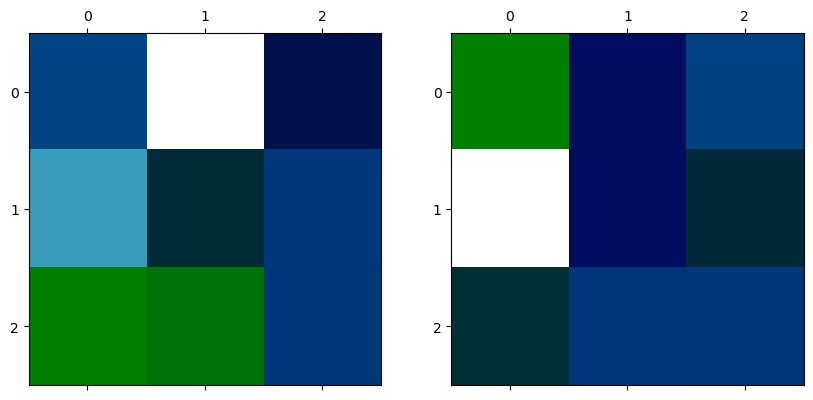

In [9]:
_, ax = plt.subplots(figsize=(10, 5), ncols = 2)
ax[1].matshow(mean(result.posteriors[:T_transition]), cmap="ocean")
ax[2].matshow(T_transition_true, cmap="ocean")
plt.gcf()

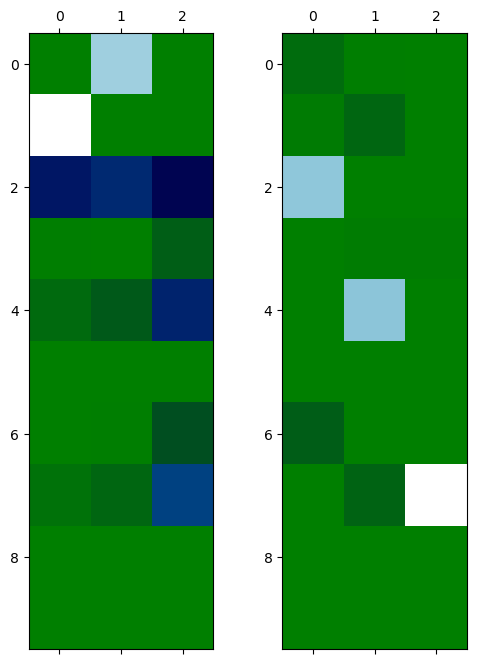

In [10]:
_, ax = plt.subplots(figsize=(6, 8), ncols = 2)
ax[1].matshow(mean(result.posteriors[:T_observation]), cmap="ocean")
ax[2].matshow(T_observation_true, cmap="ocean")
plt.gcf()

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(1:length(categories_unsupervised), categories_unsupervised)
plt.scatter(1:length(categories_unsupervised), argmax.(probvec.(result.posteriors[:z_unsupervised])[1:end-1]), marker="x", color="red")
plt.gcf()

UndefVarError: UndefVarError: `categories_unsupervised` not defined

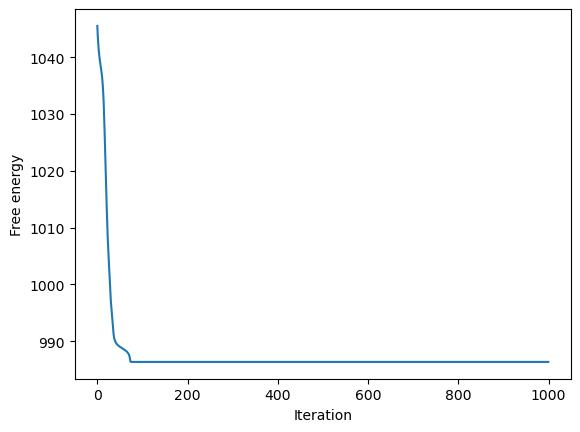

In [12]:
plt.figure()
plt.plot(result.free_energy)
plt.xlabel("Iteration")
plt.ylabel("Free energy")
plt.gcf()